# ML-7. ПРОГНОЗИРОВАНИЕ БИОЛОГИЧЕСКОГО ОТВЕТА
Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода 
- GridSeachCV, 
- RandomizedSearchCV, 
- Hyperopt, 
- Optuna

хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [4]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV #сетка
from sklearn.model_selection import RandomizedSearchCV #случайный поиск
import hyperopt
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [5]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец `Activity` содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

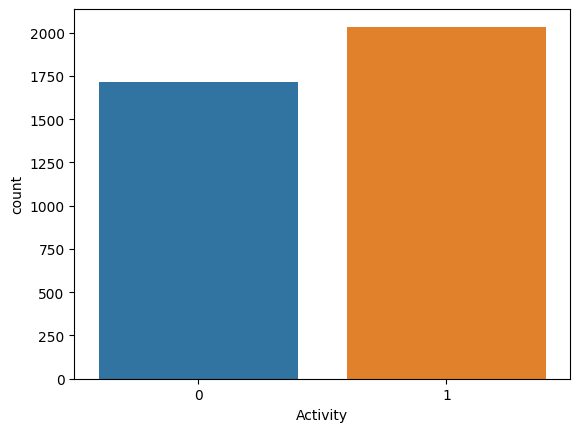

In [6]:
# Смотрим на сбалансированность классов:
sns.countplot(data=data, x='Activity');

Создаем матрицу наблюдений 𝑋 и вектор ответов 𝑦

In [7]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

#### Логистическая регрессия
Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [9]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


#### Случайный лес
Проделаем аналогичное для RandomForestClassifier(). Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [10]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировачном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировачном наборе: 1.00
f1_score на тестовом наборе: 0.80


# GRIDSEARCHCV

#### Логистическая регрессия

In [11]:
param_grid = {'penalty': ['l2', None] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 10.5 s
Wall time: 57.6 s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


#### Попробуем расширить сетку гиперпараметров.

In [12]:
param_grid = [
              {'penalty': ['l2', None] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 43.1 s
Wall time: 8min
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Метрику опять не удалось улучшить, а время потратили много, в 7 раз больше!**

Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_.

In [13]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=1000, random_state=42)


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_.

In [14]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.75


#### Случайный лес

In [15]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 1.84 s
Wall time: 20.9 s
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Наилучшее значение точности кросс-валидации

In [16]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search_forest.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.79


# RandomizedSearchCV

#### Логистическая регрессия

In [17]:
param_distributions = {'penalty': ['l2', None] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 11.1 s
Wall time: 2min 1s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}


In [18]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


#### Случайный лес

In [19]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.27 s
Wall time: 12.8 s
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 26}


In [20]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search_forest.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.79


# Вывод по базовой оптимизации:
GRIDSEARCHCV:
- Логистическая регрессия:
  - f1_score на тестовом наборе: 0.78
- Случайный лес:
  - f1_score на тестовом наборе: 0.80
  
RandomizedSearchCV:
- Логистическая регрессия:
  - f1_score на тестовом наборе: 0.78
- Случайный лес:
  - f1_score на тестовом наборе: 0.81

На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

# HYPEROPT
#### Логистическая регрессия

In [21]:
import hyperopt
# проверим установленную версию Hyperopt
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [22]:
# зададим пространство поиска гиперпараметров
pen = ['l1', 'l2']
sol = ['liblinear', 'saga']
space={'penalty': hp.choice('penalty', ['l1', 'l2']), # тип регуляризации
       'solver': hp.choice('solver', ['liblinear', 'saga']), # алгоритм оптимизации
       'C': hp.uniform('C', low=0.01, high=1) # уровень силы регурялизации
      }

In [23]:
# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': (params['penalty']), 
              'solver': (params['solver']), 
             'C': (params['C'])
              }
  
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
       **params,
        random_state=random_state,
        max_iter=50
    )

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [24]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  5%|▌         | 1/20 [00:01<00:24,  1.27s/trial, best loss: -0.779494746167446]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 15%|█▌        | 3/20 [00:06<00:36,  2.17s/trial, best loss: -0.7841071594645037]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 5/20 [00:12<00:36,  2.41s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 6/20 [00:16<00:40,  2.88s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 45%|████▌     | 9/20 [00:22<00:23,  2.09s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 11/20 [00:28<00:20,  2.28s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▌   | 13/20 [00:33<00:15,  2.28s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 14/20 [00:38<00:18,  3.10s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [00:44<00:11,  2.96s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▌ | 17/20 [00:48<00:09,  3.23s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [00:53<00:07,  3.68s/trial, best loss: -0.7904516202991784]

e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [00:59<00:00,  2.98s/trial, best loss: -0.7904516202991784]
Наилучшие значения гиперпараметров {'C': 0.2200949458234019, 'penalty': 0, 'solver': 1}
CPU times: total: 26.7 s
Wall time: 59.6 s


In [25]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C'])
)


model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


e:\Курс DS-3.0\Python_3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Случайный лес

In [26]:
%%time
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score_rf = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [01:13<00:00,  3.67s/trial, best loss: -0.9868380777471687]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
CPU times: total: 37.1 s
Wall time: 1min 15s


# OPTUNA

#### Логистическая регрессия

In [27]:
random_state = 42

def optuna_lr(trial):
  
  # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float('C', 0.1, 1)  

  # создаем модель
    model=linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C, 
        random_state=random_state,
        max_iter=50        
    )   
  # обучаем модель
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [28]:
%%time
# cоздаем объект исследования для первого набора гиперпараметров
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=50)

# рассчитаем точность для тестовой выборки
model_lr = linear_model.LogisticRegression(**study_lr.best_params,random_state=random_state)

# применим  cross validation 
score_log_opt = cross_val_score(model_lr, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'Наилучшие значения гиперпараметров {study_lr.best_params}')
print(f'F1 for test cross validation={score_log_opt:.2f}')

[I 2023-06-19 23:37:38,224] A new study created in memory with name: LogisticRegression
[I 2023-06-19 23:37:39,127] Trial 0 finished with value: 0.7847323348367581 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.3804198982339584}. Best is trial 0 with value: 0.7847323348367581.
[I 2023-06-19 23:37:42,284] Trial 1 finished with value: 0.7868884941224039 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.30772747103963316}. Best is trial 1 with value: 0.7868884941224039.
[I 2023-06-19 23:37:45,479] Trial 2 finished with value: 0.7881475984981079 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.5022566249827206}. Best is trial 2 with value: 0.7881475984981079.
[I 2023-06-19 23:37:46,382] Trial 3 finished with value: 0.780008581545484 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.32390247533547256}. Best is trial 2 with value: 0.7881475984981079.
[I 2023-06-19 23:37:48,921] Trial 4 finished with value: 0.7783271171516252 and parameters: {

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.428482715628058}
F1 for test cross validation=0.79
CPU times: total: 1.88 s
Wall time: 2min 19s


Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [29]:
optuna.visualization.plot_optimization_history(study_lr, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [30]:
optuna.visualization.plot_param_importances(study_lr, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра penalty - тип регулязации.

#### Случайный лес

In [31]:
%%time
def optuna_gb(trial):
      # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
    max_depth = trial.suggest_int('max_depth', 15, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

      # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
      # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score
# зафксируем random_state
random_state =42
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=20)
 
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-06-19 23:39:58,416] A new study created in memory with name: RandomForestClassifier
[I 2023-06-19 23:40:01,815] Trial 0 finished with value: 0.9407114624505929 and parameters: {'n_estimators': 280, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9407114624505929.
[I 2023-06-19 23:40:03,883] Trial 1 finished with value: 0.9740458015267175 and parameters: {'n_estimators': 150, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9740458015267175.
[I 2023-06-19 23:40:06,607] Trial 2 finished with value: 0.9302042060347455 and parameters: {'n_estimators': 230, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9740458015267175.
[I 2023-06-19 23:40:08,871] Trial 3 finished with value: 0.9293544457978076 and parameters: {'n_estimators': 190, 'max_depth': 39, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9740458015267175.
[I 2023-06-19 23:40:10,432] Trial 4 finished with value: 0.9283754952758306 and parameters: {'n_

f1_score на обучающем наборе: 0.97
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
CPU times: total: 54.9 s
Wall time: 54.9 s


In [32]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [33]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_samples_leaf - минимальное число листьев

# Выводы:

Исходя из поставленной задачи классификации были обучены две модели - логистической регрессии и модель случайного леса по параметрам установленным по умолчанию(Baseline). Далее были подобраны гиперпараметры моделей 4 методами - GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna.

Можно сделать следующие выводы:

- Для модели логистической регрессии изменения гиперпараметров на метрику не повлияло (возможно надо смотреть на 3 знака после запятой) по сравнению с базовой моделью (гиперерпараметры по умолчанию)
- Для модели случайного леса метрика улучшилась при RandomizedSearchCV и Hyperopt, для остальных методов метрика не изменилась по сравнению с базовой моделью. 
- Самый времязатратный и ресурснозатратный метод - GridSeachCV в модели логистической регрессии
- Настройки по умолчанию подобраны оптимальным образом, поэтому каждый метод гиперпараметров показал улучшение score незначительное